In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from flax import linen as nn
import optax
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# benchmarks described at www.nonlinearbenchmark.org.
# here we use the cascaded two-tank system.
import nonlinear_benchmarks # ! pip instsall nonlinear_benchmarks

In [3]:
# jax random seed initialization
key = jr.key(42)

In [4]:
# hyperparameters
nx = 2
lr = 1e-3
iters = 5000

In [5]:
# get some sysid data using the nonlinear_benchmarks downloader
train, test  = nonlinear_benchmarks.Cascaded_Tanks(atleast_2d=True)

In [6]:
ny = train.y.shape[-1]
nu = train.u.shape[-1]
train_t = train.sampling_time * jnp.arange(train.u.shape[0])
test_t = train.sampling_time * jnp.arange(test.u.shape[0])

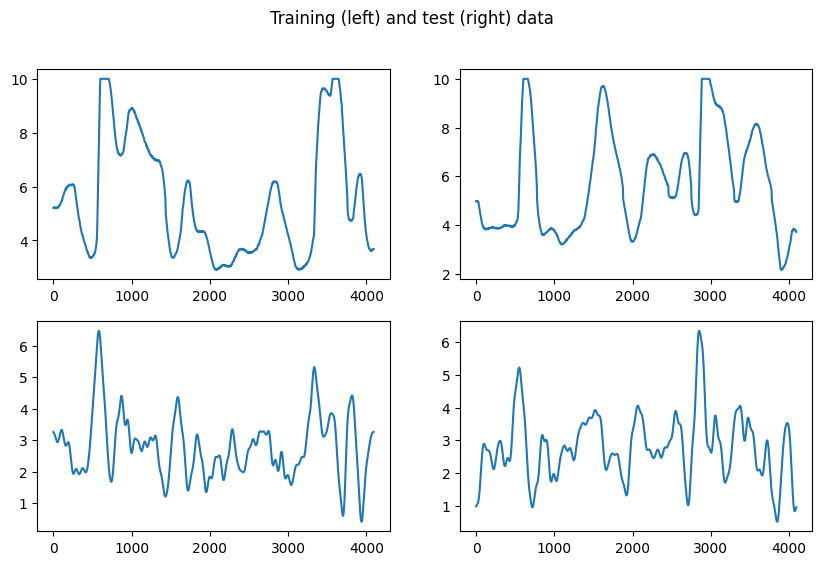

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
plt.suptitle('Training (left) and test (right) data')
ax[0, 0].plot(train_t, train.y)
ax[1, 0].plot(train_t, train.u)
ax[0, 1].plot(test_t, test.y)
ax[1, 1].plot(test_t, test.u);

Define a random state-update and output functions in a module:

\begin{align}
f(x, u) &= 0.9x + W_2^f\left(\tanh(W_1^f \begin{bmatrix}x \\ u\end{bmatrix} + b^f_1)\right) + b^f_1\\
g(x) &= W^g x + b^g\\
\end{align}

In [8]:
class LinPlusMLP(nn.Module):
    nx: int # state size
    ny: int # output size 
    hidden_size: int
    scale: float = 1e-2

    def setup(self):
        # blocks of f(x, u)
        self.f_lin1 = nn.Dense(self.hidden_size)
        self.f_lin2 = nn.Dense(self.nx)
        # blocks of g(x)
        self.g_lin = nn.Dense(self.ny)


    def __call__(self, x, u):
        
        x_new = nn.tanh(self.f_lin1(jnp.concatenate([x, u], axis=-1)))
        x_new = 0.9*x + self.scale * self.f_lin2(x_new)

        y = self.g_lin(x)
        return x_new, y


In [9]:
rnn_cell = LinPlusMLP(nx, ny, hidden_size=32)
# Set-up model parameters
key, subkey = jr.split(key, 2)
params = rnn_cell.init(subkey, jnp.ones(nx), jnp.ones(nu))

In [10]:
# example usage
x_new_, y_ = rnn_cell.apply(params, jnp.ones(nx), jnp.ones(nu))
x_new_.shape, y_.shape

((2,), (1,))

In [11]:
# define optimization variables: model parameters and initial state
opt_vars = {
    "params": params,
    "x0": jnp.zeros(nx) # initial state
}

In [12]:
# interface for state-space model simulation
def simulate_rnn(p, x0, u):
    fg_func = lambda x, u: rnn_cell.apply(p, x, u)
    xf, y = jax.lax.scan(fg_func, x0, u)
    return y, xf

y, xf = simulate_rnn(opt_vars["params"], opt_vars["x0"], jnp.ones((1024, nu)))
y.shape, xf.shape # output sequence, last state

((1024, 1), (2,))

In [13]:
# Rescale data
scaler_u = StandardScaler()
u = scaler_u.fit_transform(train.u).astype(jnp.float32)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(train.y).astype(jnp.float32)

In [14]:
def loss_fn(ov, y, u):
    y_hat, _ = simulate_rnn(ov["params"], ov["x0"], u)
    return jnp.mean((y - y_hat)**2)

In [15]:
loss_fn(opt_vars, y, u)

Array(0.9884313, dtype=float32)

In [16]:
# Setup optimizer
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(opt_vars)
loss_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

# Training loop
LOSS = []
for iter in (pbar := tqdm(range(iters))):
        loss_val, grads = loss_grad_fn(opt_vars, y, u)
        updates, opt_state = optimizer.update(grads, opt_state)
        opt_vars = optax.apply_updates(opt_vars, updates)
        LOSS.append(loss_val)
        if iter % 100 == 0:
            pbar.set_postfix_str(f"Loss step {iter}: {loss_val}")

100%|██████████| 5000/5000 [00:13<00:00, 373.33it/s, Loss step 4900: 0.003395344829186797] 


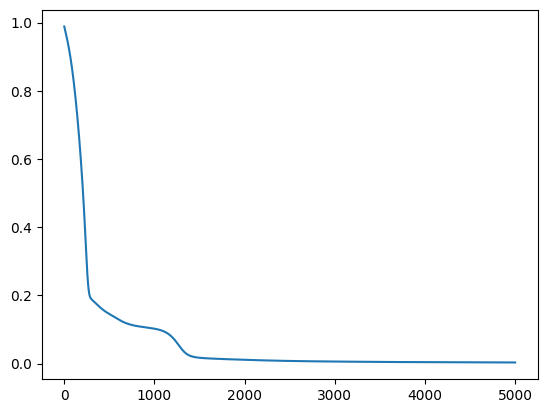

In [17]:
plt.figure()
plt.plot(LOSS)

In [18]:
y_test_hat, _ = simulate_rnn(opt_vars["params"], opt_vars["x0"], scaler_u.transform(test.u).astype(jnp.float32))
y_test_hat = scaler_y.inverse_transform(y_test_hat)

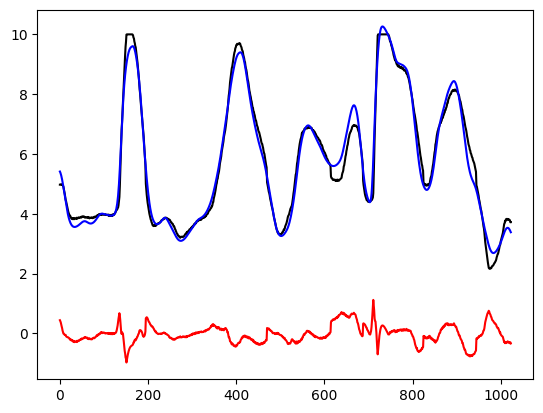

In [19]:
plt.figure()
plt.plot(test.y, "k")
plt.plot(y_test_hat, "b")
plt.plot(y_test_hat - test.y, "r")
plt.show()

In [20]:
y_train_hat, _ = simulate_rnn(opt_vars["params"], opt_vars["x0"], u)
y_train_hat = scaler_y.inverse_transform(y_train_hat)

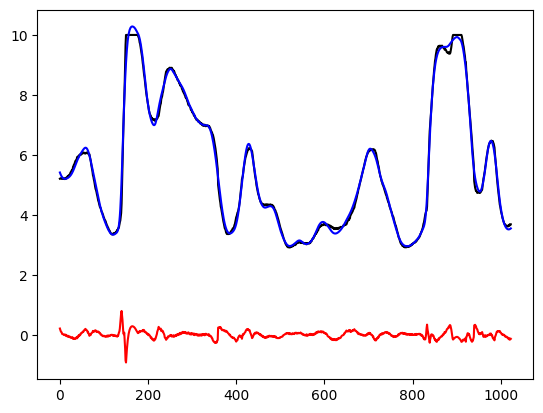

In [21]:
plt.figure()
plt.plot(train.y, "k")
plt.plot(y_train_hat, "b")
plt.plot(y_train_hat - train.y, "r")
plt.show()